# 📊 Proyecto: Análisis y visualización de la calidad del aire: una exploración de contaminantes atmosféricos y su relación con el PM2.5
**Curso:** Samsung Innovation Campus – Módulo de Python (Ecuador 2025)  
**Seccion:** EC03  

---

## 🧩 Módulo: Adquisición de Datos

En esta sección se carga el dataset, se explora su estructura general y se validan los rangos de los contaminantes.

El dataset contiene mediciones de diferentes gases y partículas contaminantes en el aire, registradas con fecha y hora.


### 📘 Descripción general de las columnas del dataset

| Columna | Descripción | Relevancia |
|----------|--------------|-------------|
| 📅 **Date** | Fecha y hora del registro | Permite analizar variaciones temporales. |
| 🏭 **CO** | Monóxido de carbono (ppm) | Gas tóxico, indicador de combustión incompleta. |
| 🚗 **NO** | Óxido nítrico | Se genera en la quema de combustibles fósiles. |
| 🚙 **NO2** | Dióxido de nitrógeno | Contaminante urbano, precursor del ozono. |
| 🌫️ **O3** | Ozono troposférico | Se forma con NOx + luz solar; irritante respiratorio. |
| 🌋 **SO2** | Dióxido de azufre | Proviene de la quema de carbón y petróleo. |
| ☁️ **PM2.5** | Partículas finas < 2.5 μm | Altamente dañinas, ingresan a los pulmones. |
| 🌧️ **PM10** | Partículas < 10 μm | Menos dañinas, quedan en vías respiratorias. |
| 🍃 **NH3** | Amoníaco | De origen agrícola, contribuye a partículas secundarias. |


In [2]:
!pip install pandas matplotlib seaborn plotly dash dash-bootstrap-components jupyter-dash

  Using cached matplotlib-3.10.6-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached retrying-1.4.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached charset_normalizer-3.4.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━

In [2]:
# ===== Importar librerías principales ====
import pandas as pd
import numpy as np
import warnings
import importlib
import src.data_acquisition as da
import src.data_processing as dp
import src.data_visualization as dv
import src.data_interpretation as di

# Recargar los módulos para reflejar cambios recientes
importlib.reload(dp) 
importlib.reload(da)
importlib.reload(dv)
importlib.reload(di)

warnings.filterwarnings('ignore')

In [3]:
# === Listar los archivos disponibles en la carpeta de datos ===
print("="*60)
print("📂 Archivos disponibles en la carpeta")
print("="*60)
for file in da.list_data_files("data"):
    print(f"- {file}")

📂 Archivos disponibles en la carpeta
- data/delhiaqi.csv


In [4]:
!ls

data  main.ipynb  README.md  src


In [5]:
# Cargar de los datos del archivo CSV en un DataFrame
df_air_quality = da.load_data_csv('data/delhiaqi.csv')

✅ Archivo 'data/delhiaqi.csv' cargado exitosamente.


In [6]:
print("=" * 60)
print("📊 Exploración inicial de los datos")
print("=" * 60)

# Mostrar filas del DataFrame
da.preview_data(df_air_quality, num_rows=5)

📊 Exploración inicial de los datos

🔍 Primeras 5 filas del DataFrame:


,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


In [7]:
# Mostrar dimensiones del DataFrame
da.get_dataframe_shape(df_air_quality)


📐 Dimensiones del DataFrame: 561 filas y 9 columnas


In [8]:
# Mostrar información detallada del DataFrame
da.get_dataframe_info(df_air_quality)


🧱 Columnas del Dataframe:
['date', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

📊 Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    561 non-null    object 
 1   co      561 non-null    float64
 2   no      561 non-null    float64
 3   no2     561 non-null    float64
 4   o3      561 non-null    float64
 5   so2     561 non-null    float64
 6   pm2_5   561 non-null    float64
 7   pm10    561 non-null    float64
 8   nh3     561 non-null    float64
dtypes: float64(8), object(1)
memory usage: 39.6+ KB


In [9]:
# Mostrar los valores faltantes por columna
da.get_missing_values(df_air_quality)


❗ Valores faltantes por columna:
date     0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64


## 🧩 Módulo: Procesamiento y limpieza de datos
En esta sección se prepara el conjunto de datos para el análisis.  
Se aplican los siguientes pasos:

1. Conversión de fechas al formato `datetime`.  
2. Eliminación de duplicados y valores negativos.  
3. Creación de columnas temporales (año, mes, día, hora).  
4. Cálculo automático del **Índice de Calidad del Aire (ICA)** basado en PM2.5.
5. Clasificación automática de cada registro en su categoría correspondiente según su valor de PM2.5.

### 🔹 Índice de Calidad del Aire (ICA)
El ICA mide la calidad del aire en una escala de **0 a >500**, dividiéndose en seis categorías de peligrosidad.  
A mayor índice, peor es la calidad del aire.  

| Categoría | Color | Rango ICA |
|-----------|-------|-----------|
| Buena | 🟢 Verde | 0 – 50 |
| Moderada | 🟡 Amarillo | 51 – 100 |
| Dañina para grupos sensibles | 🟠 Naranja | 101 – 150 |
| Dañina | 🔴 Rojo | 151 – 200 |
| Muy dañina | 🟣 Morado | 201 – 300 |
| Peligrosa | 🟤 Marrón | >300 |


In [10]:
# Limpiar y preparar los datos
df_clean = dp.clean_dataframe(df_air_quality)

# Agregar columna de categorías ICA (Índice de Calidad del Aire)
df_clean = dp.add_ica_category(df_clean)

# Mostrar las primera filas procesadas
da.preview_data(df_clean, num_rows=5)

✅ Datos limpios y listos para el análisis.

🔍 Primeras 5 filas del DataFrame:


,co,no,no2,o3,so2,pm2_5,pm10,nh3,year,month,day,hour,ica_category
date,,,,,,,,,,,,,
2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83,2023,1,1,0,Dañina
2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66,2023,1,1,1,Dañina
2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40,2023,1,1,2,Muy dañina
2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55,2023,1,1,3,Muy dañina
2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19,2023,1,1,4,Muy dañina


In [11]:
# Reporte de calidad de datos
reporte = dp.quality_report(df_clean)

print("📋 Reporte de Calidad de Datos:")
for key, value in reporte.items():
    print(f"{key}: {value}")

📋 Reporte de Calidad de Datos:
rows: 561
cols: 13
duplicates: 0
inferred_freq: h
missing: {'co': 0, 'no': 0, 'no2': 0, 'o3': 0, 'so2': 0, 'pm2_5': 0, 'pm10': 0, 'nh3': 0, 'year': 0, 'month': 0, 'day': 0, 'hour': 0, 'ica_category': 0}


In [12]:
# Estadísticas descriptivas
desc = dp.descriptives(df_clean)
print("📊 Estadísticas descriptivas por contaminante:")
display(desc)

📊 Estadísticas descriptivas por contaminante:


,count,mean,std,min,p05,p50,p95,max
co,561.0,3814.942210,3227.744681,654.22,1188.28,2590.18,11428.83,16876.22
no,561.0,51.181979,83.904476,0.00,0.00,13.30,236.03,425.58
no2,561.0,75.292496,42.473791,13.37,26.39,63.75,159.03,263.21
o3,561.0,30.141943,39.979405,0.00,0.00,11.80,124.45,164.51
so2,561.0,64.655936,61.073080,5.25,17.64,47.21,177.38,511.17
pm2_5,561.0,358.256364,227.359117,60.10,128.92,301.17,844.98,1310.20
pm10,561.0,420.988414,271.287026,69.08,158.34,340.90,1035.78,1499.27
nh3,561.0,26.425062,36.563094,0.63,4.31,14.82,102.34,267.51


In [13]:
# Promedios y resúmenes por mes

# Crear instancia de análisis
estacion = dp.EstacionCalidadAire("Delhi", df_clean)

# Promedio mensual de PM2.5
prom_mes_pm25 = estacion.promedio_por_mes("pm2_5")
print("📈 Promedio mensual de PM2.5:")
prom_mes_pm25.head()

📈 Promedio mensual de PM2.5:


,month,pm2_5
0,1,358.256364


In [14]:
# Obtener el máximo global de PM2.5
maximo_mensual_pm25 = estacion.maximo_global("pm2_5")
print(f"🔝 Máximo global de PM2.5: {maximo_mensual_pm25}")

🔝 Máximo global de PM2.5: 1310.2


In [15]:
# Días más contaminados
dias_peores = estacion.top_n_dias_mas_contaminados("pm2_5", n=5)
print("🚨 Días más contaminados por PM2.5:")
display(dias_peores)

🚨 Días más contaminados por PM2.5:


,date,pm2_5
449,2023-01-19 17:00:00,1310.20
308,2023-01-13 20:00:00,1278.35
307,2023-01-13 19:00:00,1232.62
448,2023-01-19 16:00:00,1228.04
306,2023-01-13 18:00:00,1225.39


In [16]:
# Contar registros por categoría ICA (Índice de Calidad del Aire)
print("📊 Distribución de categorías ICA:")
display(df_clean["ica_category"].value_counts())

📊 Distribución de categorías ICA:


ica_category
Peligrosa                       282
Muy dañina                      141
Dañina                           81
Dañina para grupos sensibles     48
Moderada                          9
Name: count, dtype: int64

# Modulo Visualizacion de datos

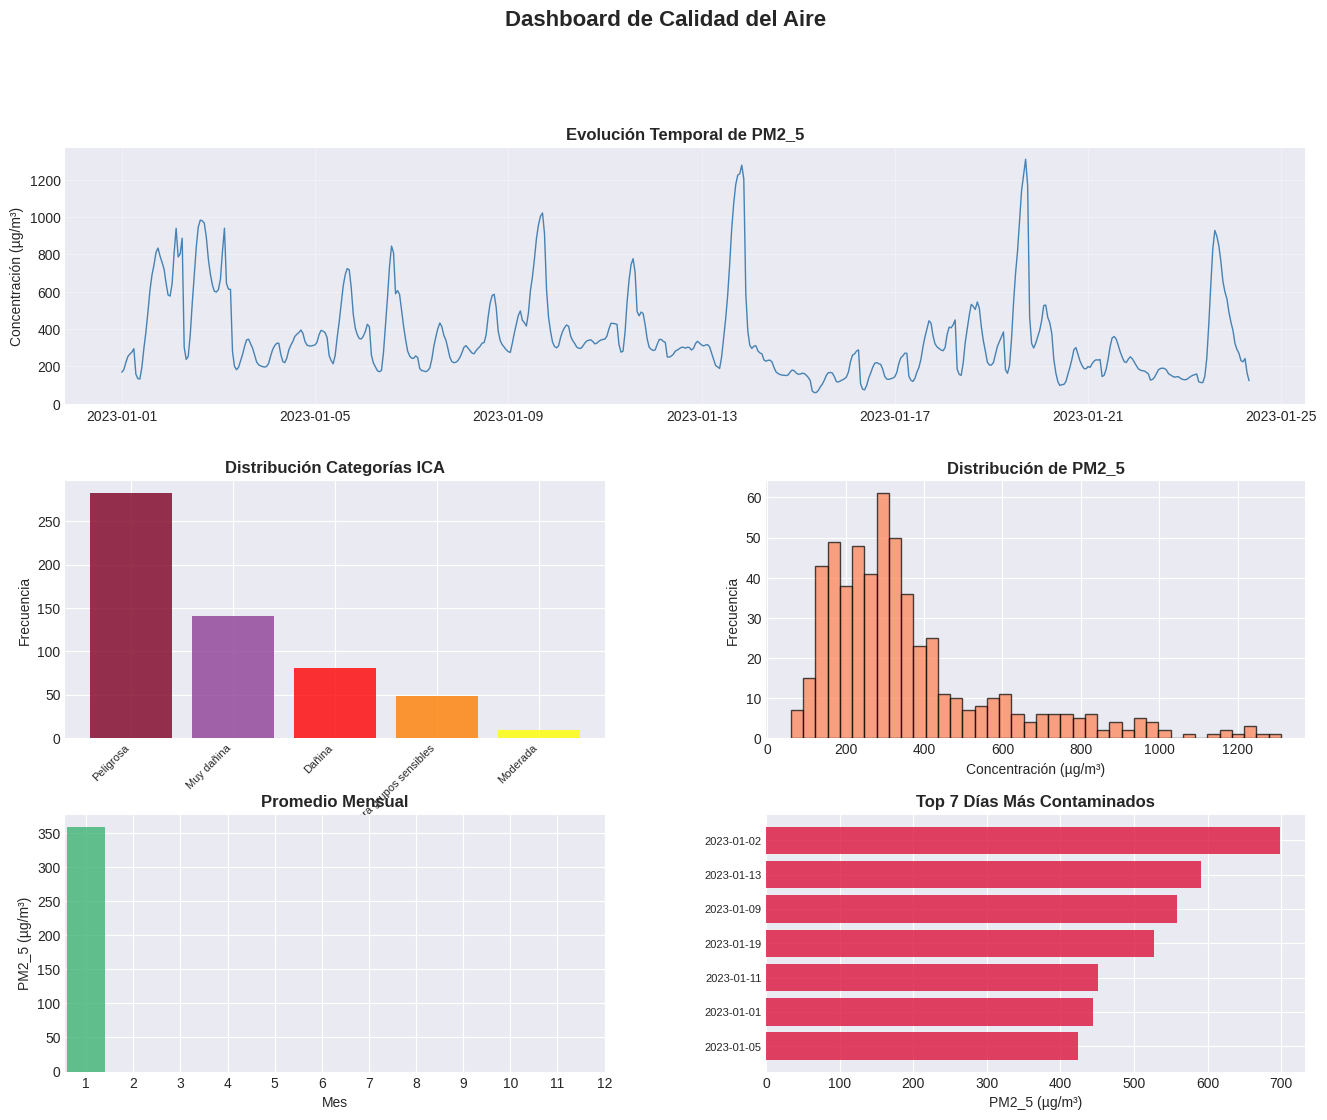

In [18]:
dv.create_dashboard_summary(df_clean)